In [607]:
import numpy as np
import random
import pandas as pd 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import math,time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import yfinance as yf

import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
import math
import random
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

### Download WTI and Brent csv daily data, fill in the gaps, visualise data, calculate the spread, normalise spread series

In [619]:
start='2015-03-01'
end='2023-01-03'
wti = pd.read_csv("wti-daily_csv.csv")
brent = pd.read_csv("brent-daily_csv.csv")

In [620]:
from datetime import date
wti['Date'] = pd.to_datetime(wti['Date'])
wti = wti.set_index('Date')
wti = wti.reindex(pd.date_range('1987-05-20', 
                         '2023-01-03', freq='D')
          ).reset_index().rename(columns={'index':'date'})
wti = wti.groupby(wti.date.dt.time).ffill()

brent['Date'] = pd.to_datetime(brent['Date'])
brent = brent.set_index('Date')
brent = brent.reindex(pd.date_range('1987-05-20', 
                         '2023-01-03', freq='D')
          ).reset_index().rename(columns={'index':'date'})
brent = brent.groupby(brent.date.dt.time).ffill()

In [621]:
wti_cleaned=wti.set_index('date')
brent_cleaned=brent.set_index('date')

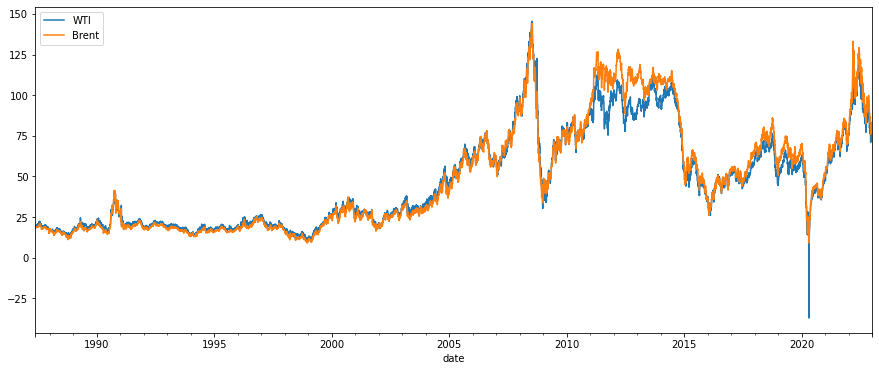

In [622]:
wti_cleaned['Price'].plot(figsize=(15,6),label='WTI')
brent_cleaned['Price'].plot(figsize=(15,6),label='Brent')
plt.legend()
plt.show()

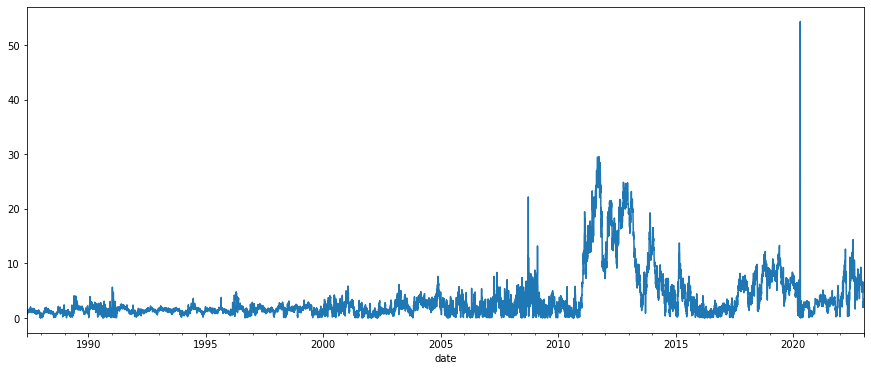

In [623]:
spread = np.abs(wti_cleaned['Price'] - brent_cleaned['Price'])
spread.plot(figsize=(15,6))
plt.show()


In [626]:
spread=spread['2015-01-01':'2023-01-03']

In [628]:
dates = pd.date_range('2015-01-01','2023-01-03',freq='D')
df1=pd.DataFrame(index=dates)
spread_df=df1.join(spread)
spread_df.head()

,Price
2015-01-01,1.82
2015-01-02,2.66
2015-01-03,2.66
2015-01-04,2.66
2015-01-05,1.03


In [629]:
spread_df_norm=spread_df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
spread_df_norm['Price'] = scaler.fit_transform(spread_df_norm['Price'].values.reshape(-1,1))
spread_df_norm.head()

,Price
2015-01-01,-0.933014
2015-01-02,-0.902098
2015-01-03,-0.902098
2015-01-04,-0.902098
2015-01-05,-0.962091


## Prepare spread data (train val test split), check dimensions of input and output to confirm before feeding into LSTM model, define LSTM model, instantiate model and train it with training data set

In [630]:
def data(asset, look_back):
    asset = asset
    data = []
    
    #All combinations of data given look back value
    for i in range(len(asset) - look_back): 
        data.append(asset[i: i + look_back])
    
    data = np.array(data);
    test_len = int(np.round(0.2*data.shape[0]))
    train_val_len = data.shape[0] - (test_len)
    val_len = int(np.round(0.25*train_val_len))
    train_len= data.shape[0] - (val_len)-test_len

    x_train = data[:train_len,:-1,:]
    y_train = data[:train_len,-1,:]
    
    x_val = data[train_len:train_len+val_len,:-1,:]
    y_val = data[train_len:train_len+val_len,-1,:]
    
    x_test = data[train_len+val_len:,:-1]
    y_test = data[train_len+val_len:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [631]:
look_back = 2 # choose sequence length
x_train, y_train,x_val,y_val, x_test, y_test = data(spread_df_norm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_val.shape = ',x_val.shape)
print('y_val.shape = ',y_val.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1754, 1, 1)
y_train.shape =  (1754, 1)
x_val.shape =  (584, 1, 1)
y_val.shape =  (584, 1)
x_test.shape =  (585, 1, 1)
y_test.shape =  (585, 1)


In [632]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [633]:
y_train.size(),x_train.size(),y_val.size(),x_val.size(),y_test.size(),x_test.size()

(torch.Size([1754, 1]),
 torch.Size([1754, 1, 1]),
 torch.Size([584, 1]),
 torch.Size([584, 1, 1]),
 torch.Size([585, 1]),
 torch.Size([585, 1, 1]))

In [634]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() #make hidden state 0
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #detach so can do truncated backprop 
        out = self.fc(out[:, -1, :]) 
        return out

In [635]:
input_dim = 1
hidden_dim = 10
num_layers = 5
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 10, num_layers=5, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [636]:
num_epochs = 1000
hist = np.zeros(num_epochs)
seq_dim =look_back-1  

for t in range(num_epochs):
    y_train_prediction = model(x_train) #forward pass

    loss_ = loss(y_train_prediction, y_train)
    if t % 200 == 0 and t !=0:
        print("Epoch", t, "MSE: ", loss_.item())
    hist[t] = loss_.item()
    optimiser.zero_grad()
    loss_.backward() #backward pass
    optimiser.step() #update parameters

Epoch 200 MSE:  0.012266755104064941
Epoch 400 MSE:  0.011929777450859547
Epoch 600 MSE:  0.010861359536647797
Epoch 800 MSE:  0.003706912510097027


In [637]:
y_val_prediction=model(x_val)
y_test_prediction = model(x_test)

y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_val_prediction = scaler.inverse_transform(y_val_prediction.detach().numpy())
y_val = scaler.inverse_transform(y_val.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

#root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train RMSE Score:',trainScore)
valScore = math.sqrt(mean_squared_error(y_val[:,0], y_val_prediction[:,0]))
print('Val RMSE Score:',valScore)
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test RMSE Score:', testScore)

Train RMSE Score: 0.8210031054666868
Val RMSE Score: 2.3447527965395163
Test RMSE Score: 0.9045835497864814


## Visualise prediction vs. actual spread of training validation and testing sets

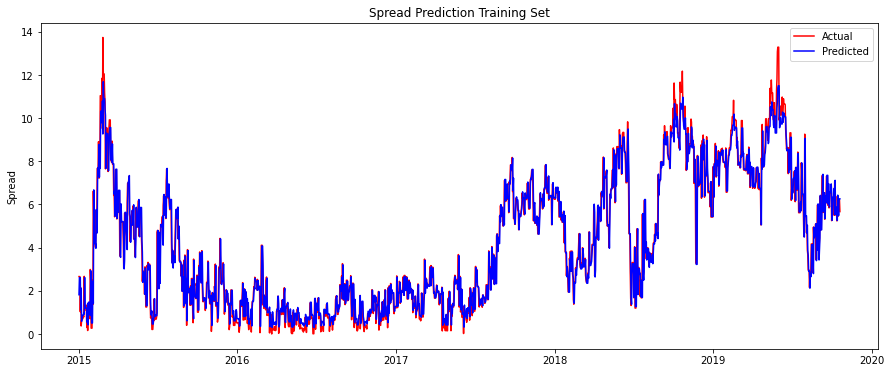

In [638]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[:len(y_train)].index, y_train, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[:len(y_train)].index, y_train_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Training Set')
plt.ylabel('Spread')
plt.legend()
plt.show()

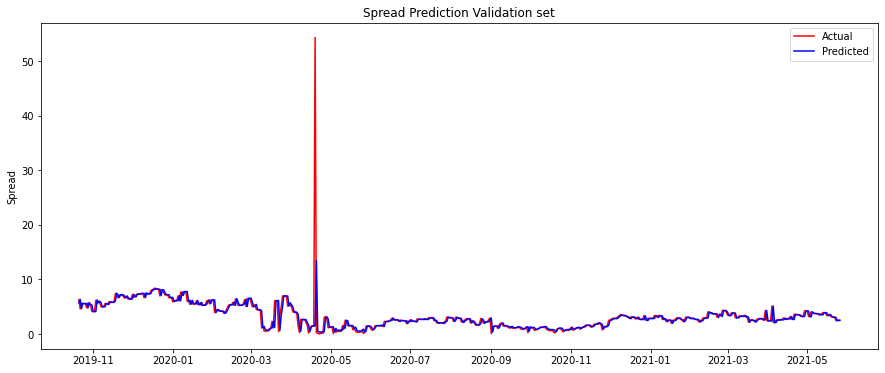

In [639]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Validation set')
plt.ylabel('Spread')
plt.legend()
plt.show()

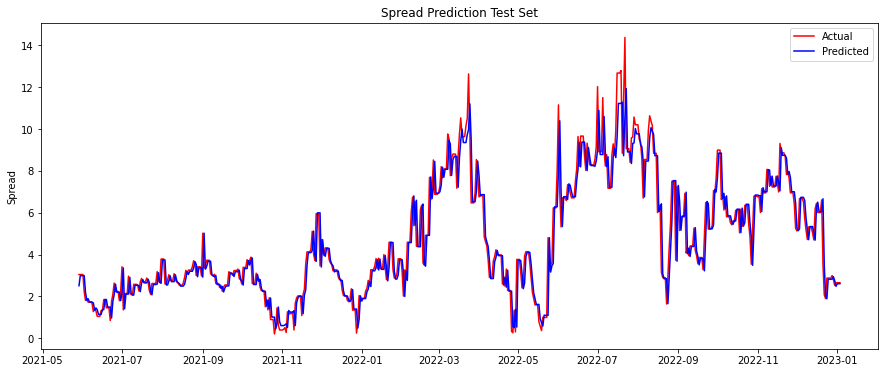

In [640]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Test Set')
plt.ylabel('Spread')
plt.legend()
plt.show()

# Define thresholds:
### decile and quintile method (see pairs-trading repository for in depth discussion about how to pick optimal threshold (specifically part 13: LSTM)
### calculate top and bottom decile and quintile thresholds using training set
### backtest each method on validation set whichever yields better result -> use on testing set

In [641]:
ydf=spread_df[0:len(y_train)].fillna(method='ffill')
y_perc_change=ydf.pct_change().fillna(method='bfill')['Price']
negchange=[]
poschange=[]
for i in range(0,len(y_perc_change)):
    if y_perc_change[i]>= 0:
        poschange.append(y_perc_change[i])
    else:
        negchange.append(y_perc_change[i])

In [642]:
pospercentile=np.percentile(poschange, np.arange(0, 100, 20))
negpercentile=np.percentile(negchange, np.arange(0, 100, 20))
top_quintile_threshold = pospercentile[-1]
bottom_quintile_threshold = negpercentile[1]

pospercentile=np.percentile(poschange, np.arange(0, 100, 10))
negpercentile=np.percentile(negchange, np.arange(0, 100, 10))
top_decile_threshold = pospercentile[-1]
bottom_decile_threshold = negpercentile[1]

In [643]:
print('Top quintile threshold:',top_quintile_threshold,'Bottom quintile threshold:',bottom_quintile_threshold)
print('Top decile threshold:',top_decile_threshold,'Bottom decile threshold:',bottom_decile_threshold)

Top quintile threshold: 0.2820165745856368 Bottom quintile threshold: -0.3923774954627931
Top decile threshold: 0.6819423745653163 Bottom decile threshold: -0.5959418250058669


In [644]:
#Percent change between forecast spread at time t+1 and actual spread at time 2
def percentage_change(col1,col2):
    return ((col2 - col1) / col1) 
perc_change=[]
for i in range(0,len(y_val)-1):
    
    percΔ=percentage_change(y_val[i],y_val_prediction[i+1])
    perc_change.append(percΔ)
perc_change.append(0)
    
perc=np.array(perc_change)

/var/folders/mw/jqcldt8d1b123hbd_qm1f0xw0000gn/T/ipykernel_8411/3782355358.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return ((col2 - col1) / col1)
/var/folders/mw/jqcldt8d1b123hbd_qm1f0xw0000gn/T/ipykernel_8411/3782355358.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  perc=np.array(perc_change)


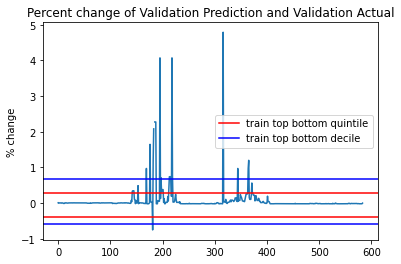

In [646]:
plt.plot(perc)
plt.axhline(y = bottom_quintile_threshold, color = 'r', linestyle = '-',label='train top bottom quintile')
plt.axhline(y = top_quintile_threshold, color = 'r', linestyle = '-')
plt.axhline(y = bottom_decile_threshold, color = 'b', linestyle = '-',label='train top bottom decile')
plt.axhline(y = top_decile_threshold, color = 'b', linestyle = '-')
plt.title('Percent change of Validation Prediction and Validation Actual')
plt.ylabel('% change')
plt.legend()
plt.show()

In [647]:
below_quint=[]
above_quint=[]
below_dec=[]
above_dec=[]
for i in range(0,len(perc)):
    if perc[i]<= bottom_quintile_threshold:
        below_quint.append(i)
    elif perc[i] >= top_quintile_threshold:
        above_quint.append(i)
        
    if perc[i]<= bottom_decile_threshold:
        below_dec.append(i)
    elif perc[i] >= top_decile_threshold:
        above_dec.append(i)

In [648]:
x_quint_long=[]
y_quint_long=[]
x_dec_long=[]
y_dec_long=[]

x_quint_short=[]
y_quint_short=[]
x_dec_short=[]
y_dec_short=[]

val_spread=spread_df[len(y_train):len(y_train)+len(y_val)]
for i in range(0,len(below_quint)):
    x_quint_long.append(val_spread.index[below_quint[i]])
    y_quint_long.append(val_spread['Price'][below_quint[i]])

for i in range(0,len(above_quint)):
    x_quint_short.append(val_spread.index[above_quint[i]])
    y_quint_short.append(val_spread['Price'][above_quint[i]])

    
for i in range(0,len(below_dec)):
    x_dec_long.append(val_spread.index[below_dec[i]])
    y_dec_long.append(val_spread['Price'][below_dec[i]])

for i in range(0,len(above_dec)):
    x_dec_short.append(val_spread.index[above_dec[i]])
    y_dec_short.append(val_spread['Price'][above_dec[i]])


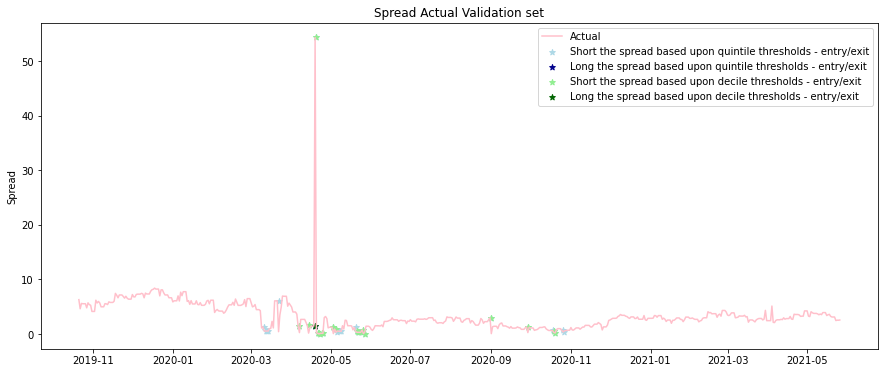

In [650]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val, color = 'pink', label = 'Actual')
plt.scatter(x_quint_short, y_quint_short, marker="*", color="lightblue",label='Short the spread based upon quintile thresholds - entry/exit')
plt.scatter(x_quint_long, y_quint_long, marker="*", color="darkblue",label='Long the spread based upon quintile thresholds - entry/exit')

plt.scatter(x_dec_short, y_dec_short, marker="*", color="lightgreen",label='Short the spread based upon decile thresholds - entry/exit')
plt.scatter(x_dec_long, y_dec_long, marker="*", color="darkgreen",label='Long the spread based upon decile thresholds - entry/exit')


plt.title('Spread Actual Validation set')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [651]:
val_spread=spread_df[len(y_train):len(y_train)+len(y_val)]
ratio = np.abs(wti_cleaned['Price']/brent_cleaned['Price'])['2015-01-01':]
x_r_quint_short=[]
y_r_quint_short=[]
x_r_quint_long=[]
y_r_quint_long=[]

x_r_dec_short=[]
y_r_dec_short=[]
x_r_dec_long=[]
y_r_dec_long=[]

val_ratio=ratio[len(y_train):len(y_train)+len(y_val)]
for i in range(0,len(below_quint)):
    x_r_quint_long.append(val_ratio.index[below_quint[i]])
    y_r_quint_long.append(val_ratio[below_quint[i]])

for i in range(0,len(above_quint)):
    x_r_quint_short.append(val_ratio.index[above_quint[i]])
    y_r_quint_short.append(val_ratio[above_quint[i]])
    
for i in range(0,len(below_dec)):
    x_r_dec_long.append(val_ratio.index[below_dec[i]])
    y_r_dec_long.append(val_ratio[below_dec[i]])
for i in range(0,len(above_dec)):
    x_r_dec_short.append(val_ratio.index[above_dec[i]])
    y_r_dec_short.append(val_ratio[above_dec[i]])
    
    
val_ratio=ratio[len(y_train):len(y_train)+len(y_val)]

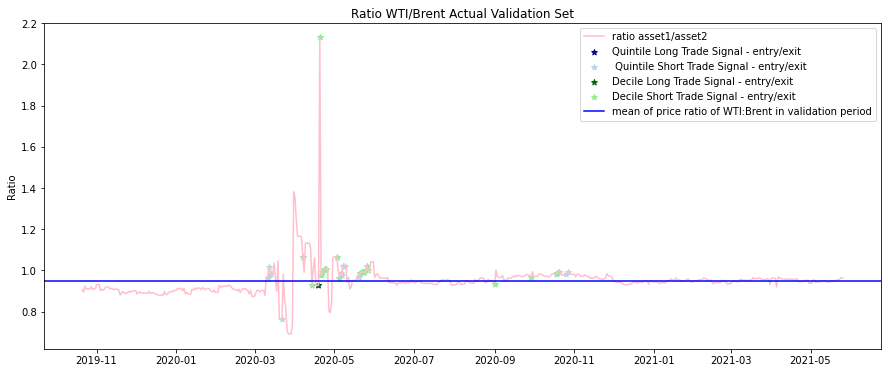

In [652]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(ratio[len(y_train):len(y_train)+len(y_val)].index, ratio[len(y_train):len(y_train)+len(y_val)], color = 'pink', label = 'ratio asset1/asset2')


plt.scatter(x_r_quint_long, y_r_quint_long, marker="*", color="darkblue",label='Quintile Long Trade Signal - entry/exit')
plt.scatter(x_r_quint_short, y_r_quint_short, marker="*", color="lightblue",label=' Quintile Short Trade Signal - entry/exit')

plt.scatter(x_r_dec_long, y_r_dec_long, marker="*", color="darkgreen",label='Decile Long Trade Signal - entry/exit')
plt.scatter(x_r_dec_short, y_r_dec_short, marker="*", color="lightgreen",label='Decile Short Trade Signal - entry/exit')


plt.axhline(y = ratio[len(y_train):len(y_train)+len(y_val)].mean(), color = 'b', linestyle = '-',label='mean of price ratio of WTI:Brent in validation period')
plt.title('Ratio WTI/Brent Actual Validation Set')
plt.ylabel('Ratio')
plt.legend()
plt.show()

In [661]:
#Quintile
trade=0
#asset 1 overvalued when ratio above mean -> sell asset 1 long asset 2
#asset 2 overvalue when ratio below mean -> sell asset2 long asset2
#calculate positions
positions_quint=pd.DataFrame(index=ratio[len(y_train):len(y_train)+len(y_val)].index, columns = ['WTI','Brent','l/s spread'])
position_open=False
for date in range(0,len(perc)):  
    #if no position is open
    if position_open==False:
        if perc[date] <= bottom_quintile_threshold:
            position_open = True
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [-1,1,'long spread']
            else:
                positions_quint.loc[val_ratio.index[date]] = [1,-1,'long spread']
        elif perc[date]>=top_quintile_threshold:
            position_open = True
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [1,-1,'short spread']
            else:
                positions_quint.loc[val_ratio.index[date]] = [-1,1,'short spread']
             
        else:
            position_open = False
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [0,0,'no change']
            else:
                positions_quint.loc[val_ratio.index[date]] = [0,0,'no change']
    

# if position is open            
    elif position_open == True:
        if perc[date] <= bottom_quintile_threshold:
            position_open= True
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [-1,1,'no change']
            else:
                positions_quint.loc[val_ratio.index[date]] = [1,-1,'no change']
        
        elif perc[date]>= top_quintile_threshold:
            position_open= True
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [1,-1,'no change']
            else:
                positions_quint.loc[val_ratio.index[date]] = [-1,1,'no change']
        else: 
            position_open=False
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions_quint.loc[val_ratio.index[date]] = [0,0,'close trade']
            else:
                positions_quint.loc[val_ratio.index[date]] = [0,0,'close trade'] 

        

In [662]:
#Check number of trades made (used when calculating fees/commisions)
trade_quint=trade
trade_quint

26

In [663]:
#Decile
#asset 1 overvalued when ratio above mean -> sell asset 1 long asset 2
#asset 2 overvalue when ratio below mean -> sell asset2 long asset2
#calculate positions
trade=0
positions=pd.DataFrame(index=ratio[len(y_train):len(y_train)+len(y_val)].index, columns = ['WTI','Brent','l/s spread'])
position_open=False
for date in range(0,len(perc)):  
    #if no position is open
    if position_open==False:
        if perc[date] <= bottom_decile_threshold:
            position_open = True
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [-1,1,'long spread']
            else:
                positions.loc[val_ratio.index[date]] = [1,-1,'long spread']
        elif perc[date]>=top_decile_threshold:
            position_open = True
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [1,-1,'short spread']
            else:
                positions.loc[val_ratio.index[date]] = [-1,1,'short spread']
             
        else:
            position_open = False
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [0,0,'no change']
            else:
                positions.loc[val_ratio.index[date]] = [0,0,'no change']
    

# if position is open            
    elif position_open == True:
        if perc[date] <= bottom_decile_threshold:
            position_open= True
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [-1,1,'no change']
            else:
                positions.loc[val_ratio.index[date]] = [1,-1,'no change']
        
        elif perc[date]>= top_decile_threshold:
            position_open= True
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [1,-1,'no change']
            else:
                positions.loc[val_ratio.index[date]] = [-1,1,'no change']
        else: 
            position_open=False
            trade+=1
            if val_ratio[date] >= val_ratio.mean():
                positions.loc[val_ratio.index[date]] = [0,0,'close trade']
            else:
                positions.loc[val_ratio.index[date]] = [0,0,'close trade'] 

        

In [664]:
trade_dec=trade
trade_dec

20

In [665]:
wti_fin=wti_cleaned['2015-01-01':'2023-01-03']

wti_fin['log_ret_wti'] = np.log(wti_fin['Price']) - np.log(wti_fin['Price'].shift(1))
logret_wti=wti_fin['log_ret_wti'][len(y_train):len(y_train)+len(y_val)]
logret_wti_c=logret_wti.cumsum()

brent_fin=brent_cleaned['2015-01-01':'2023-01-03']

brent_fin['log_ret_brent'] = np.log(brent_fin['Price']) - np.log(brent_fin['Price'].shift(1))
logret_brent_dec=brent_fin['log_ret_brent'][len(y_train):len(y_train)+len(y_val)]
logret_brent_c=logret_brent.cumsum()


p_dec=positions.join(logret_wti)
p_quint=positions_quint.join(logret_wti)
z_quint=p_quint.join(logret_brent).dropna()
z_dec=p_dec.join(logret_brent).dropna()

/Users/SophiaZorek/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/mw/jqcldt8d1b123hbd_qm1f0xw0000gn/T/ipykernel_8411/3684289268.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_fin['log_ret_wti'] = np.log(wti_fin['Price']) - np.log(wti_fin['Price'].shift(1))
/var/folders/mw/jqcldt8d1b123hbd_qm1f0xw0000gn/T/ipykernel_8411/3684289268.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [658]:
algo_ret_dec = (z_dec['WTI']*z_dec['log_ret_wti'].shift()+z_dec['Brent']*z_dec['log_ret_brent'].shift())
algo_ret_quint = (z_quint['WTI']*z_quint['log_ret_wti'].shift()+z_quint['Brent']*z_quint['log_ret_brent'].shift())

## Quintile threshold method performed better on validation set so that's what we will use going forward

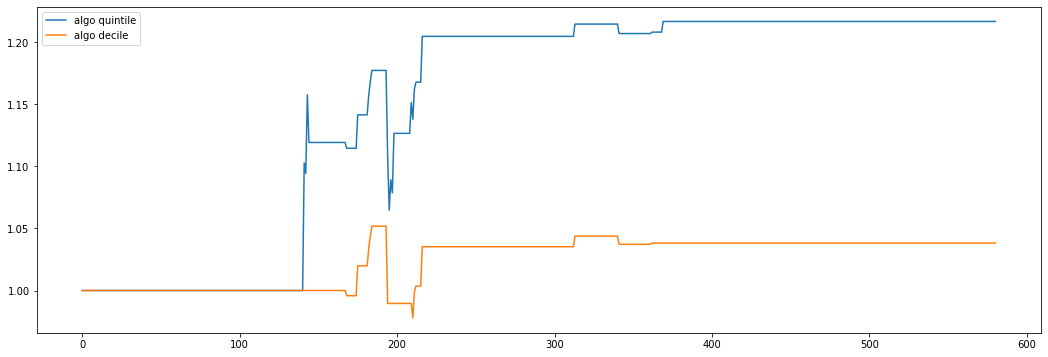

In [666]:
algo_ret_quint=algo_ret_quint.dropna()
returns_quint=[]
for i in range(0,len(algo_ret_quint)):
    returns_quint.append(np.exp(algo_ret_quint[i])-1)
    
algo_ret_dec=algo_ret_dec.dropna()
returns_dec=[]
for i in range(0,len(algo_ret_dec)):
    returns_dec.append(np.exp(algo_ret_dec[i])-1)


plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(np.array(returns_quint)+1), label='algo quintile')
plt.plot(np.nancumprod(np.array(returns_dec)+1), label='algo decile')
plt.legend()
plt.show()

In [667]:

score, pvalue, _ = coint((wti['Price']),(brent['Price']))

confidence_level = 0.05

if pvalue < confidence_level:
    print ("cointegrated")
else:
    print("not coint")
print(pvalue)

cointegrated
8.473769521750093e-05


In [669]:
def calculate_metrics(cumret):
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

## Comparison of decile quintile algo and XLE benchmark index

In [672]:
#performance metrics
index_price = yf.download('XLE', start=z.index[0], end=z.index[-1])
index_price = index_price['Adj Close']
index_ret =index_price.pct_change().dropna()

metrics = pd.DataFrame(index=['Decile Algo', 'Quintile Algo'], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown', 'Max Length Drawdown'])
metrics.loc['Decile Algo'] = calculate_metrics(np.nancumprod(np.array(returns_dec)+1))
metrics.loc['Quintile Algo'] = calculate_metrics(np.nancumprod(np.array(returns_quint)+1))
metrics.loc['XLE'] = calculate_metrics(np.nancumprod(index_ret + 1))

metrics

[*********************100%***********************]  1 of 1 completed


,Total return,APR,Sharpe,Max Drawdown,Max Length Drawdown
Decile Algo,0.038182,0.016385,0.340925,-0.070263,387.0
Quintile Algo,0.216515,0.088726,0.856387,-0.095518,39.0
XLE,-0.016089,-0.010141,0.238156,-0.606046,349.0
